### **Clonnig German Traffic signs from bitbucket**

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


.p are the files used to store encrpted form of arrays.
From the csv files it is clear that there are 43 classes ranging from 0-42.

### **Importing libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

%matplotlib inline

In [ ]:
np.random.seed(0)

### **Loading data**

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

### **Extraction of features and lables**

In [ ]:
train_data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [ ]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


The depth is 3 as the immages are RGB

In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

In [ ]:
data.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


### **Visualization**

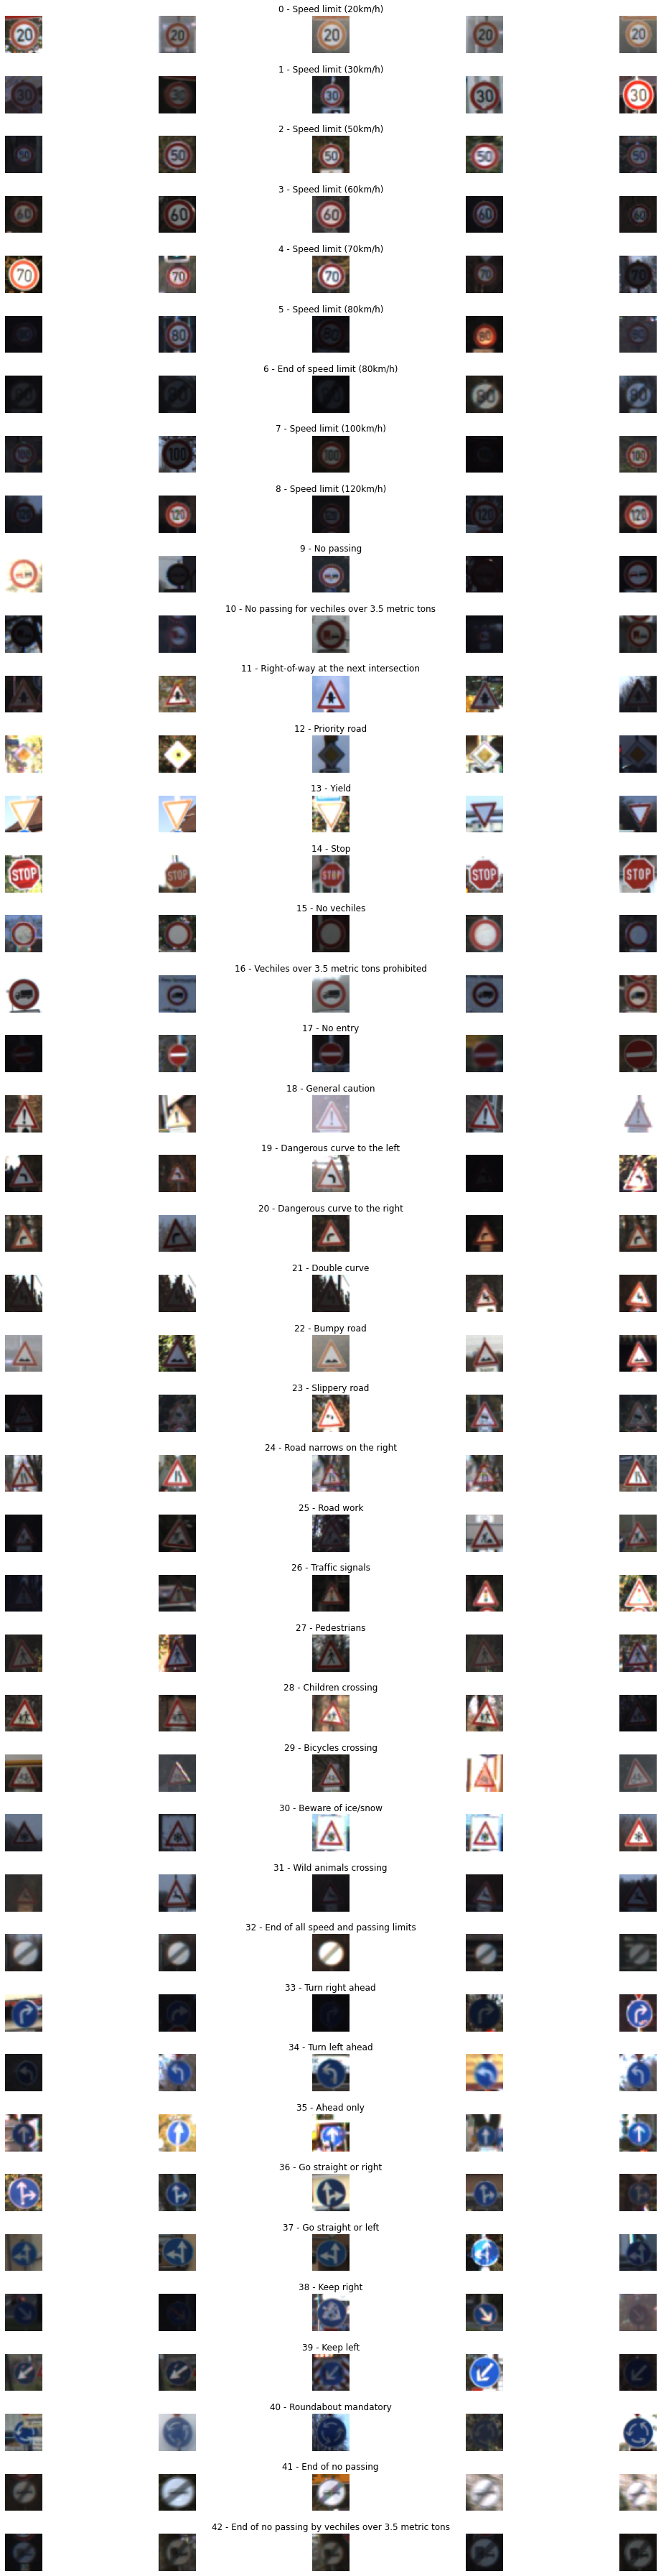

In [ ]:
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(15,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

In [ ]:
print(num_of_samples)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


### ** Bar graph**

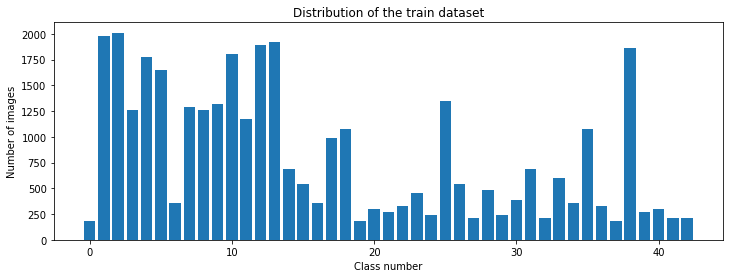

In [ ]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

The data among the various classes is not distributed evenly.

# **Preprocessing the images**


---


In [ ]:
import cv2

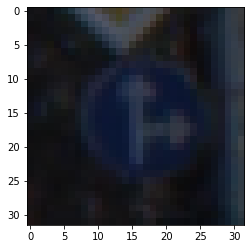

In [ ]:
plt.imshow(X_train[1000])

In [ ]:
y_train[1000]

36

In [ ]:
data[data.ClassId == 36]

,ClassId,SignName
36,36,Go straight or right


In [ ]:
X_train[1000].shape

(32, 32, 3)

**We need to convert the image to grayscale**

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

Testing grayscale

(-0.5, 31.5, 31.5, -0.5)

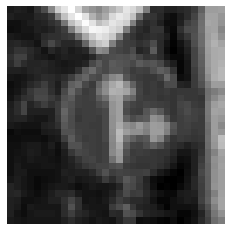

In [ ]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis("off")

**Now we need to equalize the image.**

Equalization means to spread the brightness evenly in an image. This helps is better extraction of features.

An example of it:
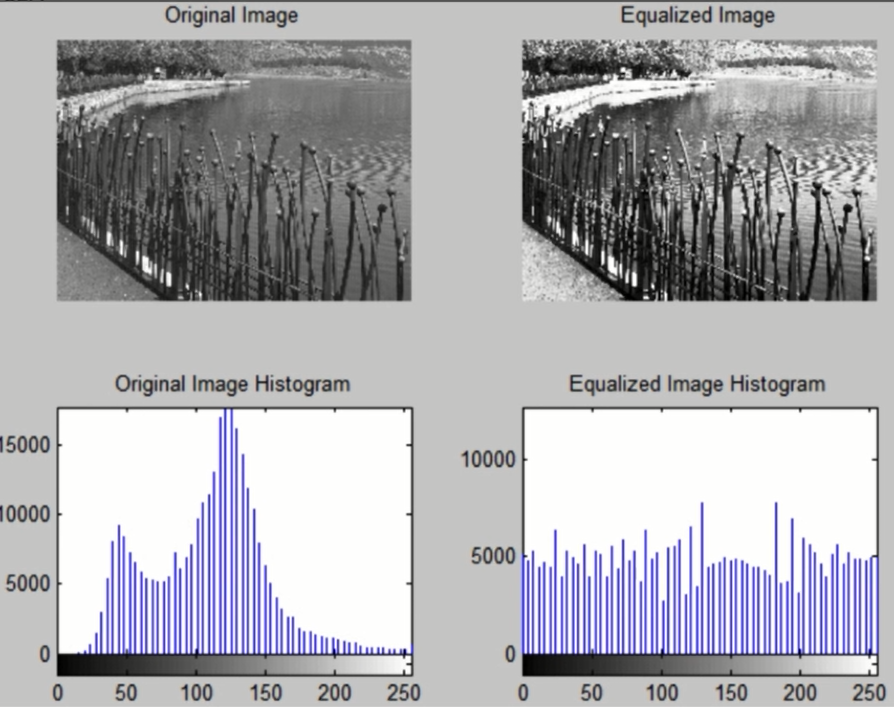

In [ ]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

Testing equalization

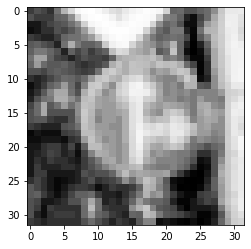

In [ ]:
img = equalize(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))

## **Combining the functions**

In [ ]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [ ]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

In [ ]:
X_train.shape

(34799, 32, 32)

Adding depth 1 for CNN

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [ ]:
X_train.shape

(34799, 32, 32, 1)

# **Le Net Model CNN**


---


In [ ]:
def leNet_model_1():
  model = Sequential()
  model.add(Conv2D(30, (5,5), input_shape=(32, 32, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(15, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = leNet_model_1()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 30)        780       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 30)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 15)        4065      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 15)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 540)               0         
                                                                 
 dense_2 (Dense)             (None, 500)              

In [ ]:
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
y_train[:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
h = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 [==============================] - 1s 11ms/step - loss: 2.4119 - accuracy: 0.3348 - val_loss: 1.1124 - val_accuracy: 0.6726
Epoch 2/10
87/87 [==============================] - 1s 9ms/step - loss: 0.8531 - accuracy: 0.7303 - val_loss: 0.6304 - val_accuracy: 0.8136
Epoch 3/10
87/87 [==============================] - 1s 9ms/step - loss: 0.5872 - accuracy: 0.8130 - val_loss: 0.5084 - val_accuracy: 0.8415
Epoch 4/10
87/87 [==============================] - 1s 9ms/step - loss: 0.4964 - accuracy: 0.8421 - val_loss: 0.5355 - val_accuracy: 0.8295
Epoch 5/10
87/87 [==============================] - 1s 9ms/step - loss: 0.4390 - accuracy: 0.8586 - val_loss: 0.4720 - val_accuracy: 0.8571
Epoch 6/10
87/87 [==============================] - 1s 9ms/step - loss: 0.3812 - accuracy: 0.8789 - val_loss: 0.4307 - val_accuracy: 0.8705
Epoch 7/10
87/87 [==============================] - 1s 9ms/step - loss: 0.3526 - accuracy: 0.8855 - val_loss: 0.4426 - val_accuracy: 0.8683
Epoch 8/10
87/87 [=

Text(0.5, 0, 'Epochs')

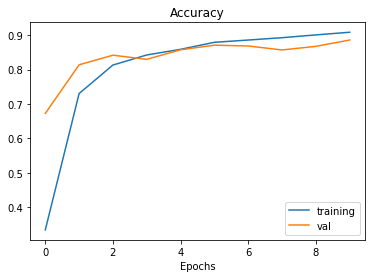

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['training', 'val'])
plt.title('Accuracy')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

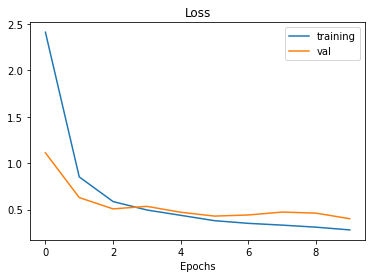

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'val'])
plt.title('Loss')
plt.xlabel('Epochs')

We can see that the val_acc is 88% and the val_loss is 0.5 which is very high. Also the training accuracy is far greater than val accuracy that means overfitting is there. We need to configure the model so as to reduce val loss.

In [ ]:
def leNet_model_2():
  model = Sequential()
  # increase filters by x2
  model.add(Conv2D(60, (5,5), input_shape=(32, 32, 1), activation='relu'))
  # Adding a new conv layer
  model.add(Conv2D(60, (5,5), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # filter 2x
  model.add(Conv2D(30, (3, 3), activation='relu'))
  # adding another layer
  model.add(Conv2D(30, (3, 3), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  # adding another dropout layer
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  # reduce lr from 0.01 to 0.001
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = leNet_model_2()

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

In [ ]:
h = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 [==============================] - 3s 30ms/step - loss: 2.4632 - accuracy: 0.3383 - val_loss: 0.7570 - val_accuracy: 0.7871
Epoch 2/10
87/87 [==============================] - 2s 28ms/step - loss: 0.7345 - accuracy: 0.7723 - val_loss: 0.3193 - val_accuracy: 0.9052
Epoch 3/10
87/87 [==============================] - 2s 28ms/step - loss: 0.4136 - accuracy: 0.8716 - val_loss: 0.2018 - val_accuracy: 0.9415
Epoch 4/10
87/87 [==============================] - 2s 28ms/step - loss: 0.2869 - accuracy: 0.9121 - val_loss: 0.1507 - val_accuracy: 0.9537
Epoch 5/10
87/87 [==============================] - 2s 28ms/step - loss: 0.2264 - accuracy: 0.9306 - val_loss: 0.1177 - val_accuracy: 0.9626
Epoch 6/10
87/87 [==============================] - 2s 28ms/step - loss: 0.1882 - accuracy: 0.9408 - val_loss: 0.1061 - val_accuracy: 0.9698
Epoch 7/10
87/87 [==============================] - 2s 28ms/step - loss: 0.1603 - accuracy: 0.9507 - val_loss: 0.0913 - val_accuracy: 0.9728
Epoch 8/10
87

Text(0.5, 0, 'Epochs')

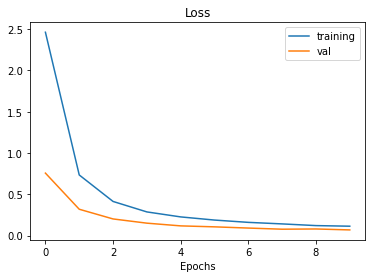

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'val'])
plt.title('Loss')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

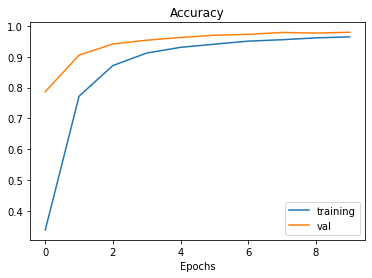

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['training', 'val'])
plt.title('Accuracy')
plt.xlabel('Epochs')

We can see that the val loss is dec to about 0.1 and the val acc increased to about 97%. This is achieved by the cumilation of the little changes we did in the model.

Further we added another dropout layer of 0.5. This solved overfitting as val_loss is always below training loss. However the trainig acc suffered but is still high.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.14665153622627258
Test accuracy: 0.9562945365905762


### **Predict a random image**

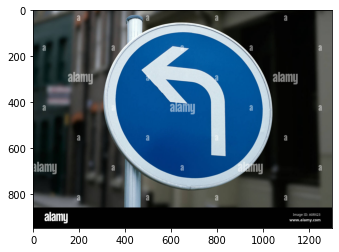

In [ ]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

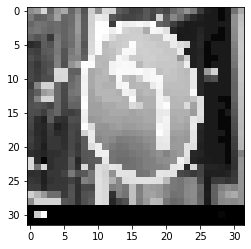

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))

In [ ]:
print(img.shape)
img = img.reshape(1, 32, 32, 1)

(32, 32)


In [ ]:
data[data.ClassId == np.argmax(model.predict(img))]

,ClassId,SignName
5,5,Speed limit (80km/h)


Incorrect

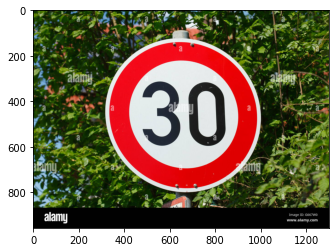

In [ ]:
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

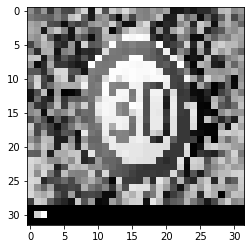

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))

In [ ]:
img = img.reshape(1, 32, 32, 1)

In [ ]:
data[data.ClassId == np.argmax(model.predict(img))]

,ClassId,SignName
1,1,Speed limit (30km/h)


Correct guess

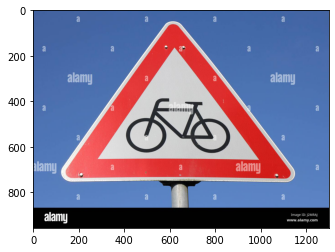

In [ ]:
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
img = img.reshape(1, 32, 32, 1)

data[data.ClassId == np.argmax(model.predict(img))]

,ClassId,SignName
31,31,Wild animals crossing


incorrect guess

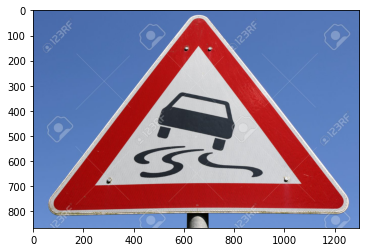

In [ ]:
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
img = img.reshape(1, 32, 32, 1)

data[data.ClassId == np.argmax(model.predict(img))]

,ClassId,SignName
23,23,Slippery road


Correct guess

## **Data augmentation**

Inorder to further train the model we will use data augmentaton which means duplicating some images and changing their width, height, zoom, sheer so as to add variety to the data set.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)

datagen.fit(X_train)

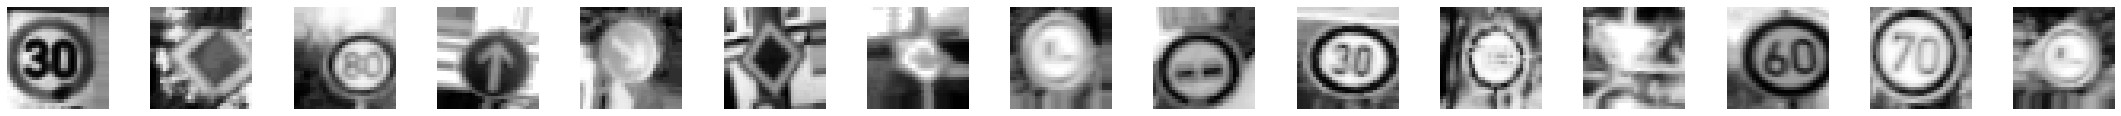

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(30, 20))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))
    axs[i].axis("off")

In [ ]:
model = leNet_model_2()

In [ ]:
len(X_train)

34799

In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=(len(X_train)//50),
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


695/695 [==============================] - 13s 19ms/step - loss: 2.2034 - accuracy: 0.3772 - val_loss: 0.6217 - val_accuracy: 0.8079
Epoch 2/10
695/695 [==============================] - 13s 18ms/step - loss: 0.9639 - accuracy: 0.7013 - val_loss: 0.2534 - val_accuracy: 0.9254
Epoch 3/10
695/695 [==============================] - 13s 18ms/step - loss: 0.6393 - accuracy: 0.8000 - val_loss: 0.1242 - val_accuracy: 0.9633
Epoch 4/10
695/695 [==============================] - 13s 18ms/step - loss: 0.4791 - accuracy: 0.8494 - val_loss: 0.0888 - val_accuracy: 0.9746
Epoch 5/10
695/695 [==============================] - 13s 18ms/step - loss: 0.4016 - accuracy: 0.8749 - val_loss: 0.0823 - val_accuracy: 0.9739
Epoch 6/10
695/695 [==============================] - 13s 19ms/step - loss: 0.3446 - accuracy: 0.8923 - val_loss: 0.0446 - val_accuracy: 0.9896
Epoch 7/10
695/695 [==============================] - 13s 18ms/step - loss: 0.3130 - accuracy: 0.9023 - val_loss: 0.0603 - val_accuracy: 0.9825
Epo

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.10676693916320801
Test accuracy: 0.970308780670166


Text(0.5, 0, 'Epochs')

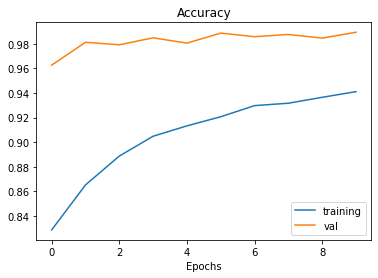

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'val'])
plt.title('Accuracy')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

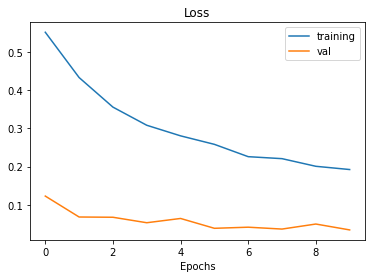

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'val'])
plt.title('Loss')
plt.xlabel('Epochs')

We need to remove some dropout layers in order to reduce the gap

In [ ]:
def leNet_model_modified():
  model = Sequential()
  # increase filters by x2
  model.add(Conv2D(60, (5,5), input_shape=(32, 32, 1), activation='relu'))
  # Adding a new conv layer
  model.add(Conv2D(60, (5,5), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # filter 2x
  model.add(Conv2D(30, (3, 3), activation='relu'))
  # adding another layer
  model.add(Conv2D(30, (3, 3), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  # removed dropout layer

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  # reduce lr from 0.01 to 0.001
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = leNet_model_modified()
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_45 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 12, 12, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_47 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 4, 4, 30)         0         
 g2D)                                                

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
544/544 [==============================] - 15s 26ms/step - loss: 1.8591 - accuracy: 0.4762 - val_loss: 0.3971 - val_accuracy: 0.8948
Epoch 2/10
544/544 [==============================] - 12s 22ms/step - loss: 0.6082 - accuracy: 0.8139 - val_loss: 0.1586 - val_accuracy: 0.9497
Epoch 3/10
544/544 [==============================] - 12s 22ms/step - loss: 0.3639 - accuracy: 0.8867 - val_loss: 0.0660 - val_accuracy: 0.9814
Epoch 4/10
544/544 [==============================] - 12s 22ms/step - loss: 0.2625 - accuracy: 0.9185 - val_loss: 0.0708 - val_accuracy: 0.9803
Epoch 5/10
544/544 [==============================] - 12s 22ms/step - loss: 0.2242 - accuracy: 0.9312 - val_loss: 0.0820 - val_accuracy: 0.9755
Epoch 6/10
544/544 [==============================] - 12s 22ms/step - loss: 0.1819 - accuracy: 0.9428 - val_loss: 0.0667 - val_accuracy: 0.9816
Epoch 7/10
544/544 [==============================] - 12s 22ms/step - loss: 0.1658 - accuracy: 0.9485 - val_loss: 0.0507 - val_accuracy:

Text(0.5, 0, 'Epochs')

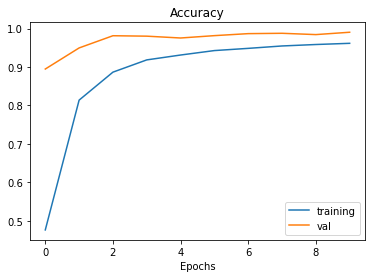

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'val'])
plt.title('Accuracy')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

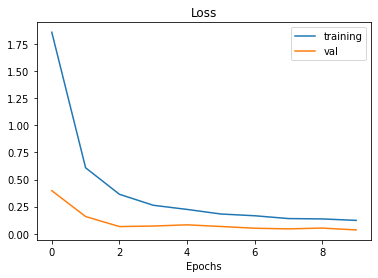

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'val'])
plt.title('Loss')
plt.xlabel('Epochs')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.109194815158844
Test accuracy: 0.9686461091041565


Lets try testing the same random images now.

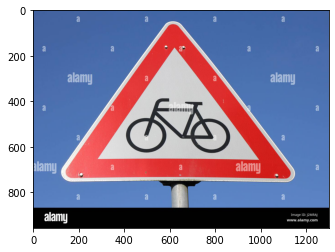

In [ ]:
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
img = img.reshape(1, 32, 32, 1)
print( np.argmax(model.predict(img), axis=-1))
data[data.ClassId == np.argmax(model.predict(img))]

[29]


,ClassId,SignName
29,29,Bicycles crossing


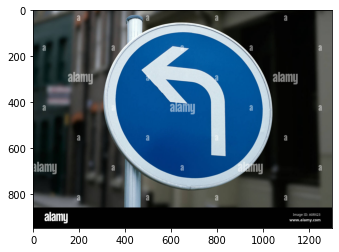

In [ ]:
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
img = img.reshape(1, 32, 32, 1)
print( np.argmax(model.predict(img), axis=-1))
data[data.ClassId == np.argmax(model.predict(img))]

[34]


,ClassId,SignName
34,34,Turn left ahead


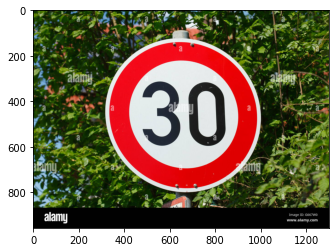

In [ ]:
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
img = img.reshape(1, 32, 32, 1)
print( np.argmax(model.predict(img), axis=-1))
data[data.ClassId == np.argmax(model.predict(img))]

[1]


,ClassId,SignName
1,1,Speed limit (30km/h)


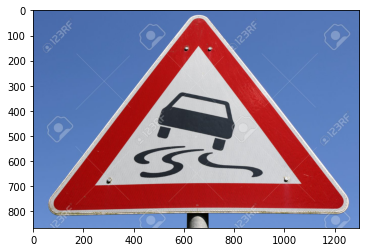

In [ ]:
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
img = img.reshape(1, 32, 32, 1)
print( np.argmax(model.predict(img), axis=-1))
data[data.ClassId == np.argmax(model.predict(img))]

[23]


,ClassId,SignName
23,23,Slippery road


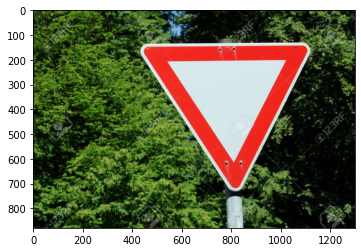

In [ ]:
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
img = img.reshape(1, 32, 32, 1)
print( np.argmax(model.predict(img), axis=-1))
data[data.ClassId == np.argmax(model.predict(img))]

[13]


,ClassId,SignName
13,13,Yield


After a lot of experimentation the batch size of 64 works well to correctly guess all the images.